# Part A

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics

sns.set()

In [2]:
penguins = pd.read_csv('penguins.csv')
penguins = penguins.dropna(how='any')
penguins.head(5)

,species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


### The pairwise relationship between different features in penguins dataset.

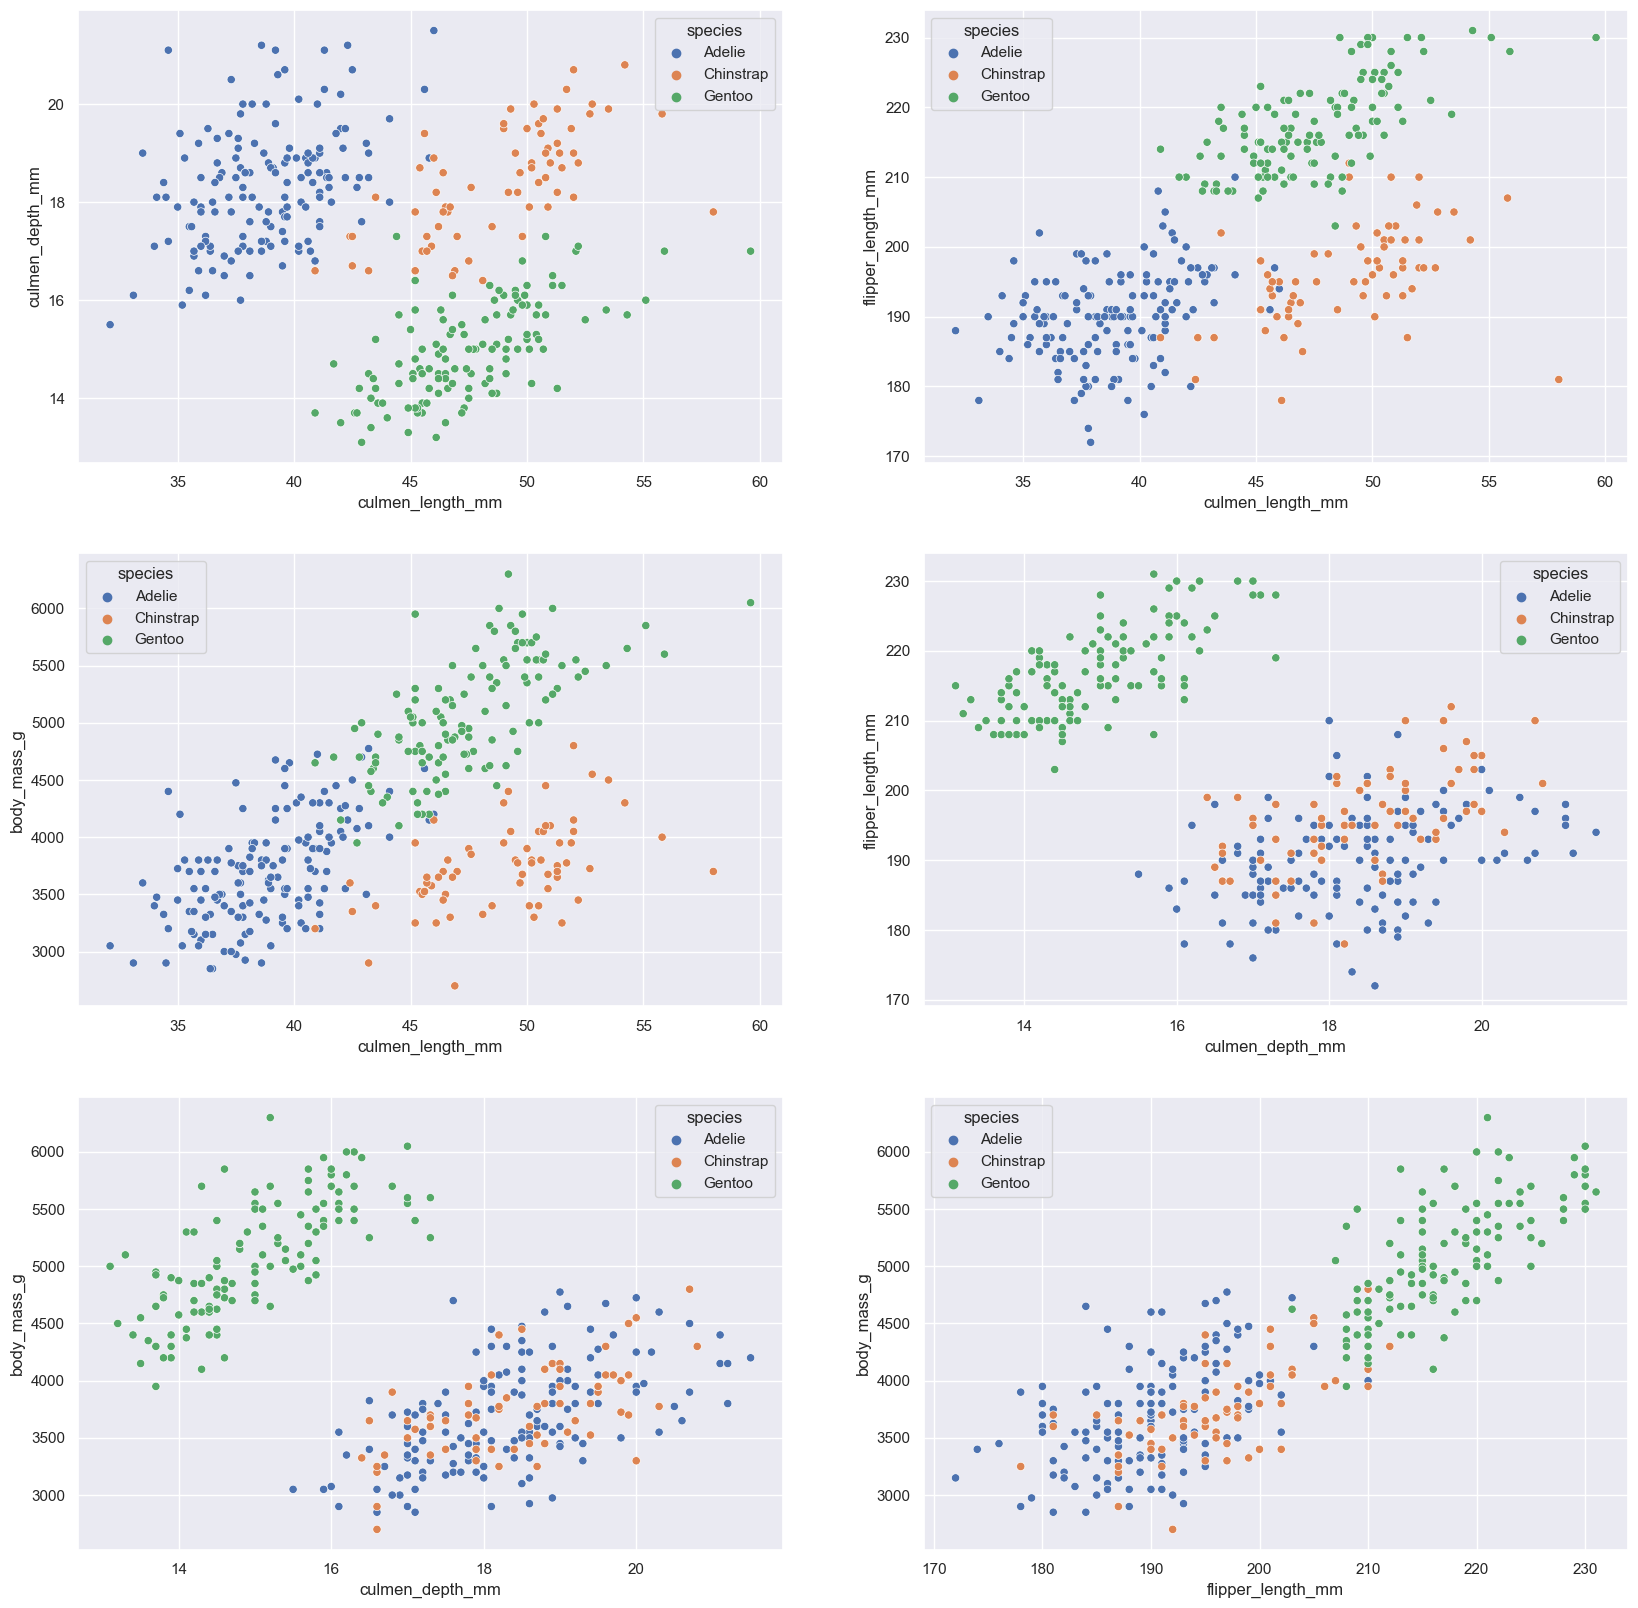

In [3]:
sns.set_theme()
fig = plt.figure(figsize=(20, 20))
k=0

for i in range(1,penguins.shape[1]):
    for j in range(i+1,penguins.shape[1]):
        k+=1
        ax = plt.subplot(3, 2, k)
        sns.scatterplot(ax=ax, data=penguins, x=penguins.iloc[:,i], y=penguins.iloc[:,j],hue=penguins.iloc[:,0])
        

It seems that features (culmen_length_mm,culmen_depth_mm) or (culmen_length_mm, flipper_length_mm) or (culmen_length_mm, body_mass_g) are good features for classifying but other pairs can't detect class Chinstrap.

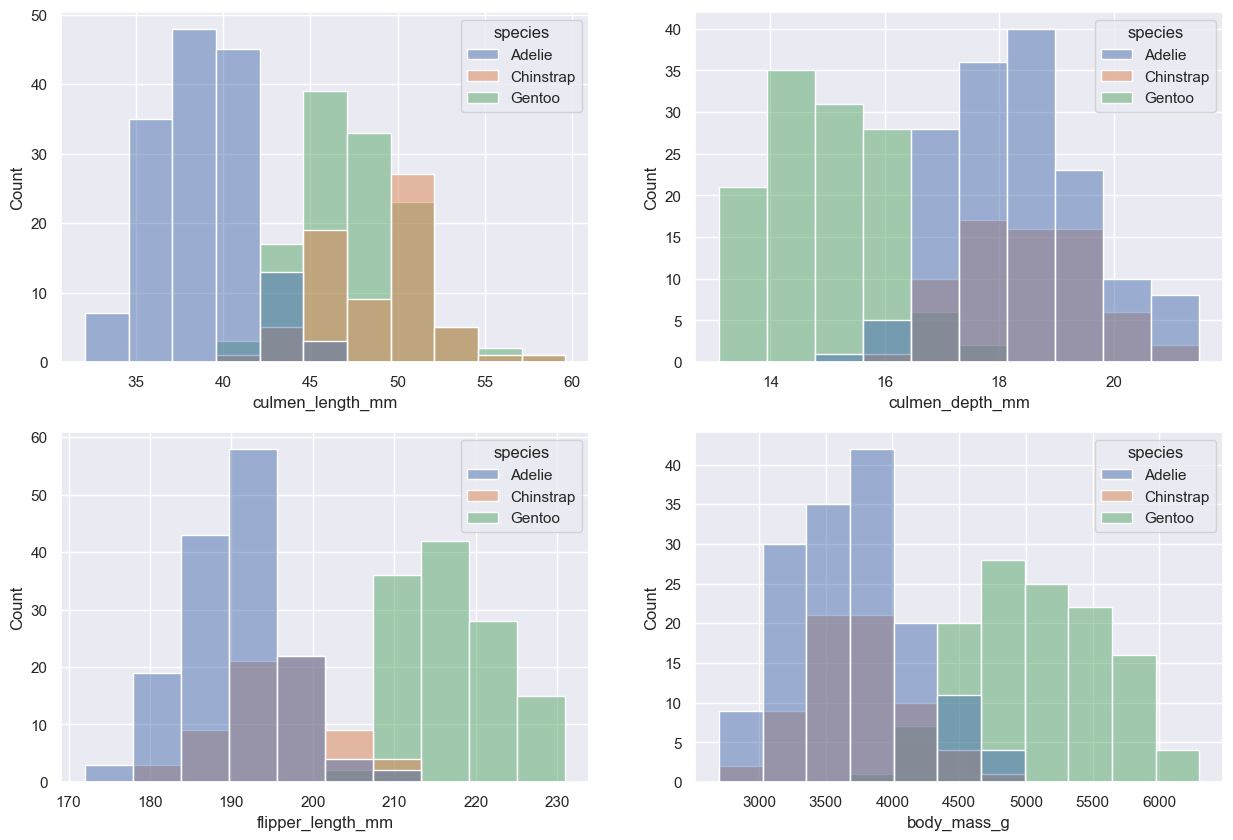

In [4]:
fig = plt.figure(figsize=(15, 10))
k = 0

for i in range(1,penguins.shape[1]):
    k+=1
    ax = plt.subplot(2, 2, k)
    sns.histplot(ax=ax, data=penguins, x=penguins.iloc[:,i], hue=penguins.iloc[:,0])


Adelie and Gentoo are almost separated, but Chinstrap is combined with both of them in all features.

# Part B

### Split dataset into random train and test subsets.

the proportion of the dataset for train and test 80 to 20.

In [5]:
msk = np.random.rand(len(penguins)) < 0.8

train = penguins[msk]
test = penguins[~msk]

In [6]:
train.reset_index( inplace=True)
y_train = train.species
X_train = train.drop(['index','species'], axis=1)

test.reset_index( inplace=True)
y_test = test.species
X_test = test.drop(['index','species'], axis=1)

#### Normalized data by:  $X-\bar{X}/SE$

In [7]:
def normalized(X):
    X_normalized = (X - np.min(X)) / (np.std(X) )
    return X_normalized

In [8]:
X_train = np.array(normalized(X_train))
X_test = np.array(normalized(X_test))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


## Model Functions

In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [10]:
def fit(X, y, alpha=0.01, epochs=10000):
    
    m = np.shape(X)[0]  
    n = np.shape(X)[1]  
    
    N_features = X.shape[1]  # total number of features
    N_samples = X.shape[0]   # total number of samples
    
    # stores the updates on the cost function (loss function)
    cost_history_list = []
    weights = []
    
    # iterate for each groups against others
    for i in np.unique(y):
        
        theta = np.random.randn(N_features)
        cost = []
        
        y_onevsall = np.where(y == i, 1, 0)
        
        # iterate until the maximum number of epochs
        for _ in range(epochs):
            
            # z = (theta.T)X, compute the dot product between our feature 'X' and weight 'W'
            # y_estimated = 1/1+exp(-z)
            y_estimated = sigmoid(np.dot(X, theta))
            
            # calculate the difference between the actual and predicted value
            error = y_estimated - y_onevsall
            
            # calculate the cost
            # cost = 1/numberOfsample * ((-y.T)(log(y_estimated)) - ((1-y).T)(log(1-y_estimated))
            cost.append((1 / N_samples) * (np.sum(np.dot(-y_onevsall.T,(np.log(y_estimated)))- \
                                                  np.dot((1 - y_onevsall).T, np.log(1 - y_estimated)))))
            
            # Update our gradient by the dot product between
            # 1/numberOfsample * (y_hat - y).X
            gradient = (1 / N_samples) * (X.T.dot(error) )
            
            #theta = theta - alpha * gradient
            # Now we have to update our weights
            theta -= alpha * gradient
            
             
           
        weights.append((theta, i))
        cost_history_list.append((cost,i))
    return weights, cost_history_list


### Feed data to model

In [11]:
weights, loss  = fit(X_train, y_train)

In [12]:
predicted = []
for i in X_test:
    cl = -1
    for t,c in weights:
        if sigmoid(np.dot(i,t))> cl:
            cl = sigmoid(np.dot(i,t))
            x1 = c
    predicted.append(x1)

## Reports

In [13]:
print("Accuracy of model is %.3f: " %(np.mean(predicted == y_test)))

Accuracy of model is 0.970: 


In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score

jaccard = jaccard_score(y_test, predicted,average=None)
print(classification_report(y_test, predicted, labels=['Adelie', 'Chinstrap', 'Gentoo']))

              precision    recall  f1-score   support

      Adelie       0.93      1.00      0.96        27
   Chinstrap       1.00      0.92      0.96        12
      Gentoo       1.00      0.96      0.98        27

    accuracy                           0.97        66
   macro avg       0.98      0.96      0.97        66
weighted avg       0.97      0.97      0.97        66



In [15]:
print('\t\tAdelie\t Chinstrap\t Gentoo')
print('jaccard\t\t%.2f\t'%(jaccard[0]), '%.2f\t\t'%(jaccard[1]),'%.2f'%(jaccard[2]))

		Adelie	 Chinstrap	 Gentoo
jaccard		0.93	 0.92		 0.96


## confusion matrix

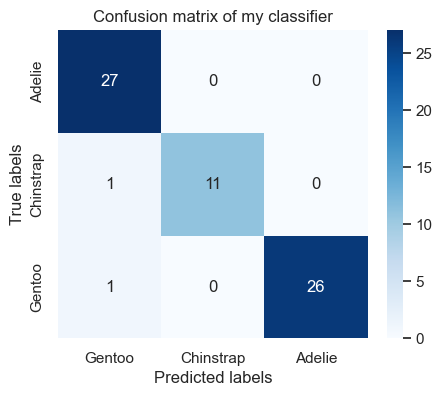

In [16]:
cf_matrix = metrics.confusion_matrix(y_test, predicted)

plt.figure(figsize=(5, 4))
ax= plt.subplot()

#annot=True to annotate cells, ftm='g' to disable scientific notation
sns.heatmap(cf_matrix, annot=True, fmt='g',cmap='Blues', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix of my classifier'); 
ax.xaxis.set_ticklabels(['Gentoo', 'Chinstrap', 'Adelie']); 
ax.yaxis.set_ticklabels(['Adelie', 'Chinstrap', 'Gentoo']);

## Loss curve

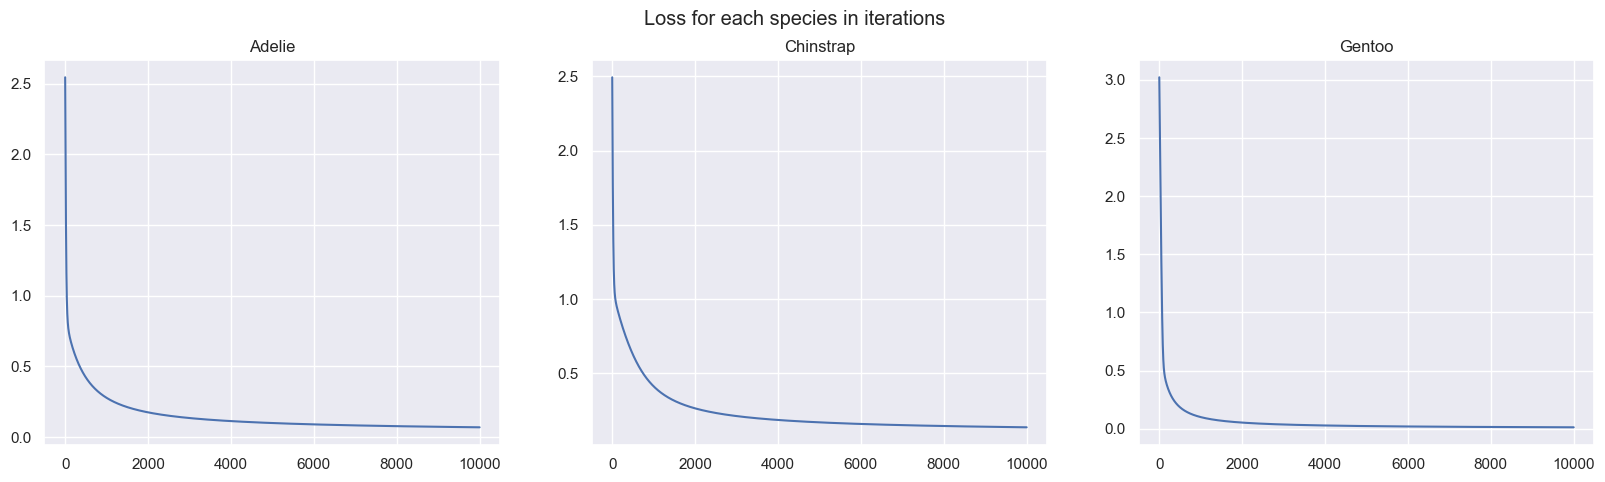

In [17]:
fig = plt.figure(figsize=(20, 5))

for i in range(1,len(loss)+1):
    ax = plt.subplot(1, 3, i)
    lineplot = sns.lineplot(ax=ax, x=np.arange(len(loss[i-1][0])), y=loss[i-1][0]).set(title=loss[i-1][1])
fig.suptitle('Loss for each species in iterations');


# Part C

### SKLEARN

Preprocess for preparing dataset

In [18]:
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize

y = np.array(penguins.species)
X = np.array(penguins.drop(['species'], axis=1))

pre = preprocessing.LabelBinarizer()
y = pre.fit_transform(y)
n_classes = y.shape[1]

In [19]:
Label = {0: 'Adelie', 1 : 'Chinstrap', 2 : 'Gentoo'}

### Split dataset into random train and test subsets.

In [20]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=.2, random_state=0)

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.fit_transform(X_test2)

### Feed data to model

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# all parameters not specified are set to their defaults
logisticRegr = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=10000))
y_score = logisticRegr.fit(X_train2, y_train2).decision_function(X_test2)

### Reports

In [23]:
predicted2 = logisticRegr.predict(X_test2)

score = logisticRegr.score(X_test2, y_test2)
print('Accuracy : %.3f'%(score))

Accuracy : 0.957


In [24]:
jaccard = jaccard_score(y_test2, predicted2, average=None)
print(classification_report(y_test2, predicted2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      0.75      0.86        12
           2       1.00      1.00      1.00        21

   micro avg       1.00      0.96      0.98        69
   macro avg       1.00      0.92      0.95        69
weighted avg       1.00      0.96      0.98        69
 samples avg       0.96      0.96      0.96        69



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print('\t\tAdelie\t Chinstrap\t Gentoo')
print('jaccard\t\t%.2f\t'%(jaccard[0]), '%.2f\t\t'%(jaccard[1]),'%.2f'%(jaccard[2]))

		Adelie	 Chinstrap	 Gentoo
jaccard		1.00	 0.75		 1.00


### confusion matrix

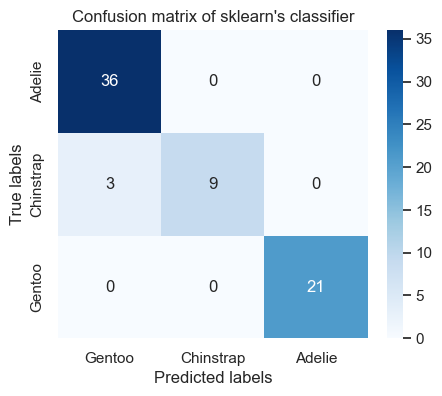

In [26]:
y_test2_original = pre.inverse_transform(y_test2)
predicted_original = pre.inverse_transform(predicted2)

cf_matrix2 = metrics.confusion_matrix(y_test2_original, predicted_original)


plt.figure(figsize=(5, 4))
ax= plt.subplot()
sns.heatmap(cf_matrix2, annot=True, fmt='g',cmap='Blues', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation


ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion matrix of sklearn\'s classifier'); 
ax.xaxis.set_ticklabels(['Gentoo', 'Chinstrap', 'Adelie']); ax.yaxis.set_ticklabels(['Adelie', 'Chinstrap', 'Gentoo']);


### ROC 

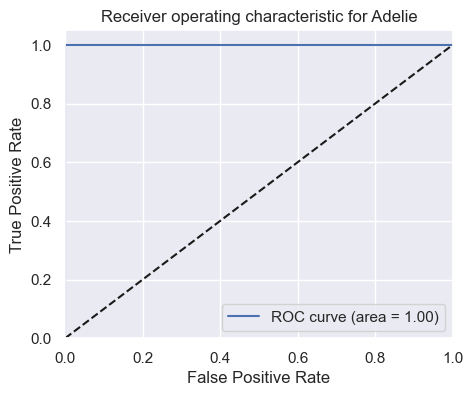

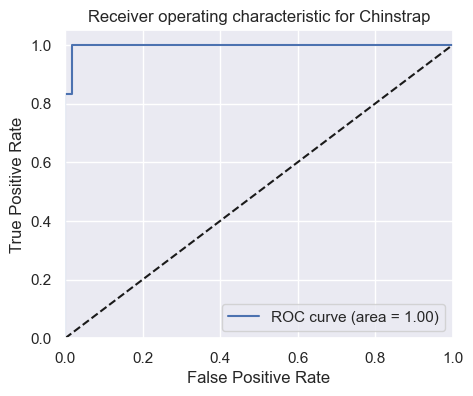

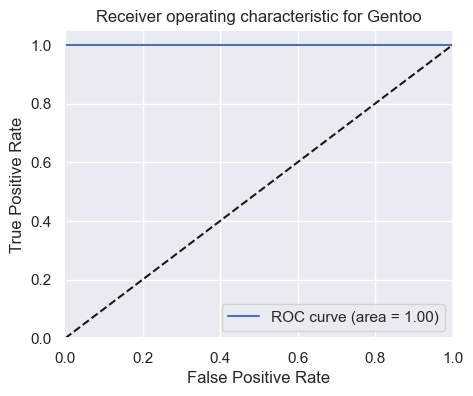

In [27]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test2.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


for i in range(n_classes):
    plt.figure(figsize=(5, 4))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for %s'%Label[i])
    plt.legend(loc="lower right")
    plt.show();
